In [23]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
# TensorFlow and tf.keras
# import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
# import urllib3

# import tensorflow_datasets as tfds

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Deepfake Dataset

In [4]:
import os
data_path = os.getenv('HOME') + '/project/dacon/crop_face_mini'

print(data_path)

/home/ubuntu/project/dacon/crop_face_mini


In [5]:
image_size = (256, 256)
batch_size = 512

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True, 
    seed=1337, 
    validation_split=0.2,
    subset='training',
    interpolation='bilinear', 
    follow_links=False
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True, 
    seed=1337, 
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear', 
    follow_links=False
)

Found 347446 files belonging to 2 classes.
Using 277957 files for training.
Found 347446 files belonging to 2 classes.
Using 69489 files for validation.


In [6]:
train_ds.map

<bound method DatasetV2.map of <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>>

In [7]:
val_ds.map

<bound method DatasetV2.map of <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>>

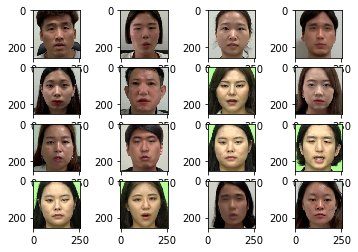

In [8]:
for img, label in train_ds.take(1):
    for i in range(4):
        for j in range(4):            
            plt.subplot(4, 4, i*4 + j + 1)
            plt.imshow(img[i*4 + j].numpy().astype(np.uint8))

In [9]:
print(label) # maybe 0 is fake, 1 is real

tf.Tensor(
[0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1
 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0
 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0
 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1
 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0
 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0
 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1
 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 1 0 1 0 0

# Input Normalization

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# ResNet Basic Block

- ResNet34

In [12]:
from tensorflow.keras import layers

In [13]:
def build_resnet_residual(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x     
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [14]:
def build_resnet_bottleneck(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 1, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    x1 = layers.Conv2D(channel * 4, 1, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [15]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        strides=1,
                        block_num=0, 
                        is_plain=False, 
                        is_50=False):
    # input layer
    x = input_layer
    if is_50:
        for i in range(num_cnn):
            if block_num == 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, conv_shortcut=True, is_plain=is_plain)
            elif block_num != 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_bottleneck(x, channel, is_plain=is_plain)
    else:
        for i in range(num_cnn):
            if block_num != 2 and i == 0:
                x = build_resnet_residual(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_residual(x, channel, is_plain=is_plain)
        
    return x

In [16]:
def build_resnet(input_shape=(224, 224, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape)
    output = input_layer
    
    # conv1
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    output = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv2_maxpool2d')(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output, 
                                    num_cnn=num_cnn, 
                                    channel=channel, 
                                    block_num=i+2,
                                    is_plain=is_plain,
                                    is_50=is_50)
        
    output = keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [17]:
resnet34 = build_resnet(input_shape=(256, 256, 3), num_classes=2) # binary -> num_classes=2

In [18]:
resnet34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

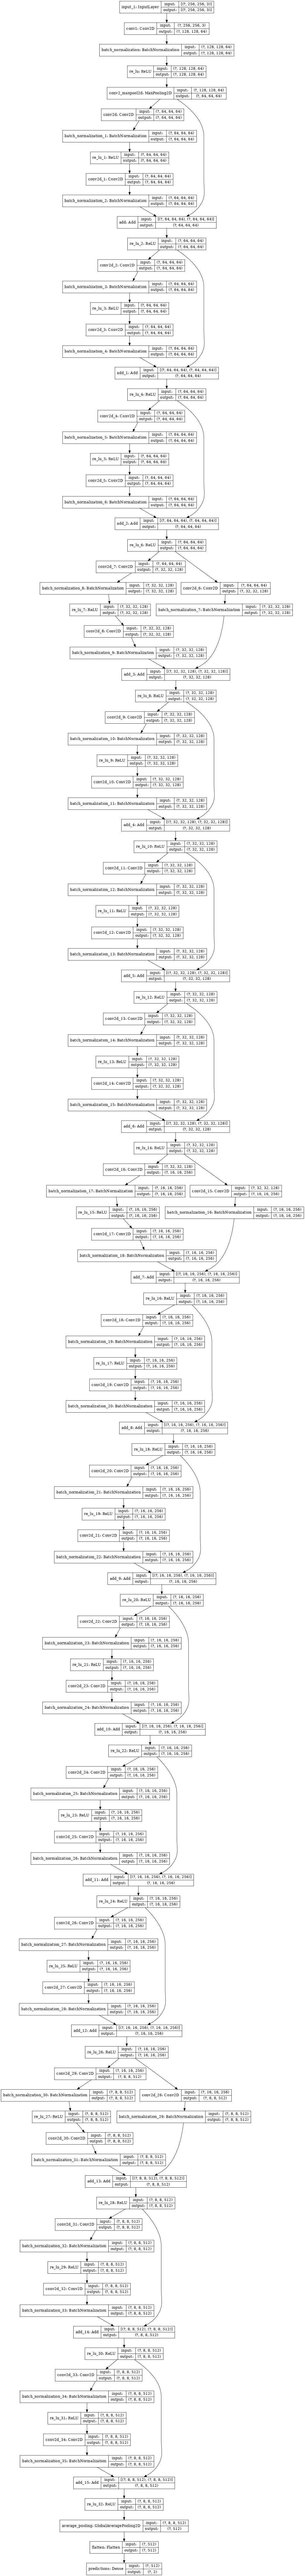

In [19]:
tf.keras.utils.plot_model(resnet34, show_shapes=True, dpi=64)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./models/best_at_{epoch}.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

In [21]:
#BATCH_SIZE = 512
EPOCH = 20

checkpoint_dir = './Models/'

In [ ]:
### resnet34.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    optimizer='Adam',
    metrics=['accuracy'],
    
)

history_34 = resnet34.fit(
    train_ds,
    # batch_size=BATCH_SIZE,
    # steps_per_epoch=int(len(train_ds)),
    # validation_steps=int(len(val_ds)),
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es, mc]
)

# Model Test

- Load model weight

In [38]:
from tensorflow import keras

resnet34 = keras.models.load_model('./models/resnet34_best_at_epoch12(0.9908)_deepfake.h5')

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
# dataGenerator = ImageDataGenerator(rescale=1./255)
dataGenerator = ImageDataGenerator(rescale=1)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


Predicted likelihood: 0.0016
Actual label: 0

Correct prediction: True


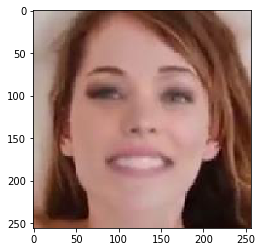

In [39]:
# Rendering image X with label y for VGG
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {resnet34.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(resnet34.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X.astype(int)));

# print(X)

In [40]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [41]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = resnet34.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.
1000  predictions completed.
2000  predictions completed.
3000  predictions completed.
4000  predictions completed.
5000  predictions completed.
6000  predictions completed.
7000  predictions completed.
All 7104 predictions completed


In [42]:
print(len(correct_deepfake))
print(len(correct_deepfake_pred))

2184
2184


In [43]:
print(len(correct_real))
print(len(correct_real_pred))

1595
1595


In [48]:
print(len(misclassified_real))

2665


In [50]:
print(len(misclassified_deepfake))

660


In [44]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j].astype(int)))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

In [45]:
print("acc :",(len(correct_real) + len(correct_deepfake)) / (len(correct_real) + len(correct_deepfake) + len(misclassified_real) + len(misclassified_deepfake)))

acc : 0.5319538288288288


In [46]:
print((len(misclassified_real) + len(misclassified_deepfake)) / (len(correct_real) + len(correct_deepfake) + len(misclassified_real) + len(misclassified_deepfake)))

0.46804617117117114
